In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import pickle
from sklearn.model_selection import GridSearchCV, train_test_split

drive.mount('/content/drive')

train_sembedpath = '/content/drive/My Drive/train_embeds.npy'
train_embeddings = np.load(train_sembedpath)
# Print the shape of the loaded data to confirm
print("Loaded data shape:", train_embeddings.shape)

Mounted at /content/drive
Loaded data shape: (142246, 1024)


In [2]:
# converting embeddings numpy array(train_embeddings) into pandas dataframe.
column_num = train_embeddings.shape[1]
train_df = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(train_df.shape)

train_df.head()

labels_df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/updated00_labels_df.pkl')
print(labels_df.shape)
labels_df.head()

(142246, 1024)
(142246, 1500)


,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0034250,GO:0140053,GO:0031345,GO:0098802,GO:0045861,GO:0051783,GO:0031674,GO:0001818,GO:0006874,GO:0016887
0,False,True,False,True,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,True,True,True,True,True,True,True,True,True,False,...,True,False,False,True,False,True,True,True,False,False
2,True,True,True,True,True,True,True,True,True,True,...,True,False,False,True,False,True,True,True,False,False
3,True,True,True,True,True,True,True,True,True,True,...,False,False,False,True,False,False,True,False,False,False
4,True,False,True,True,True,False,True,True,True,True,...,False,False,False,True,False,False,True,False,False,False


In [ ]:
# First, split the data into a training set and a temporary testing set
X_train, X_temp, y_train, y_temp = train_test_split(
    train_df, labels_df, test_size=0.2, random_state=42
)

# Next, split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Display the dimensions of the sets to verify proper splitting
print(f"Training set dimensions: {X_train.shape}, {y_train.shape}")
print(f"Validation set dimensions: {X_val.shape}, {y_val.shape}")
print(f"Test set dimensions: {X_test.shape}, {y_test.shape}")

Training set dimensions: (113796, 1024), (113796, 1500)
Validation set dimensions: (14225, 1024), (14225, 1500)
Test set dimensions: (14225, 1024), (14225, 1500)


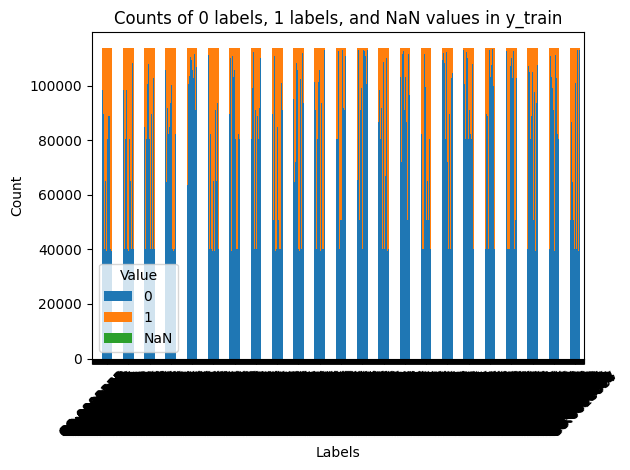

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure y_train is a DataFrame
if not isinstance(y_train, pd.DataFrame):
    y_train = pd.DataFrame(y_train)

# Count the occurrences of 0s, 1s, and NaNs for each label
counts_0 = (y_train == 0).sum()
counts_1 = (y_train == 1).sum()
counts_nan = y_train.isna().sum()

# Combine counts into a DataFrame
counts = pd.DataFrame({
    '0': counts_0,
    '1': counts_1,
    'NaN': counts_nan
})

# Plotting the counts
counts.plot(kind='bar', stacked=True, rot=45)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Counts of 0 labels, 1 labels, and NaN values in y_train')
plt.legend(title='Value')
plt.tight_layout()
plt.show()


In [ ]:
INPUT_SHAPE = [X_train.shape[1]]
BATCH_SIZE = 500
num_of_labels= 1500
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_recall_curve, auc, average_precision_score
from tensorflow.keras.utils import plot_model
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),
    tf.keras.layers.Dense(units=1024, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(units=1000, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(units=512, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.Dense(units=num_of_labels, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', tf.keras.metrics.AUC()],
)

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, y_val)
)

# Evaluate the Dense model
dense_scores = model.evaluate(X_test, y_test)

# Calculate F1 score and AUPR for the Dense model
dense_predictions = model.predict(X_test)
dense_f1 = f1_score(y_test, np.round(dense_predictions), average='micro')
dense_aupr = average_precision_score(y_test, dense_predictions)



Epoch 1/20
228/228 [==============================] - 101s 422ms/step - loss: 0.6310 - binary_accuracy: 0.8048 - auc: 0.8650 - val_loss: 0.4589 - val_binary_accuracy: 0.7925 - val_auc: 0.8461
Epoch 2/20
228/228 [==============================] - 88s 388ms/step - loss: 0.4167 - binary_accuracy: 0.8116 - auc: 0.8760 - val_loss: 0.4338 - val_binary_accuracy: 0.8028 - val_auc: 0.8641
Epoch 3/20
228/228 [==============================] - 90s 394ms/step - loss: 0.4162 - binary_accuracy: 0.8122 - auc: 0.8766 - val_loss: 0.4198 - val_binary_accuracy: 0.8103 - val_auc: 0.8738
Epoch 4/20
228/228 [==============================] - 96s 423ms/step - loss: 0.4158 - binary_accuracy: 0.8127 - auc: 0.8770 - val_loss: 0.4158 - val_binary_accuracy: 0.8103 - val_auc: 0.8759
Epoch 5/20
228/228 [==============================] - 89s 389ms/step - loss: 0.4148 - binary_accuracy: 0.8132 - auc: 0.8776 - val_loss: 0.4159 - val_binary_accuracy: 0.8105 - val_auc: 0.8755
Epoch 6/20
228/228 [========================

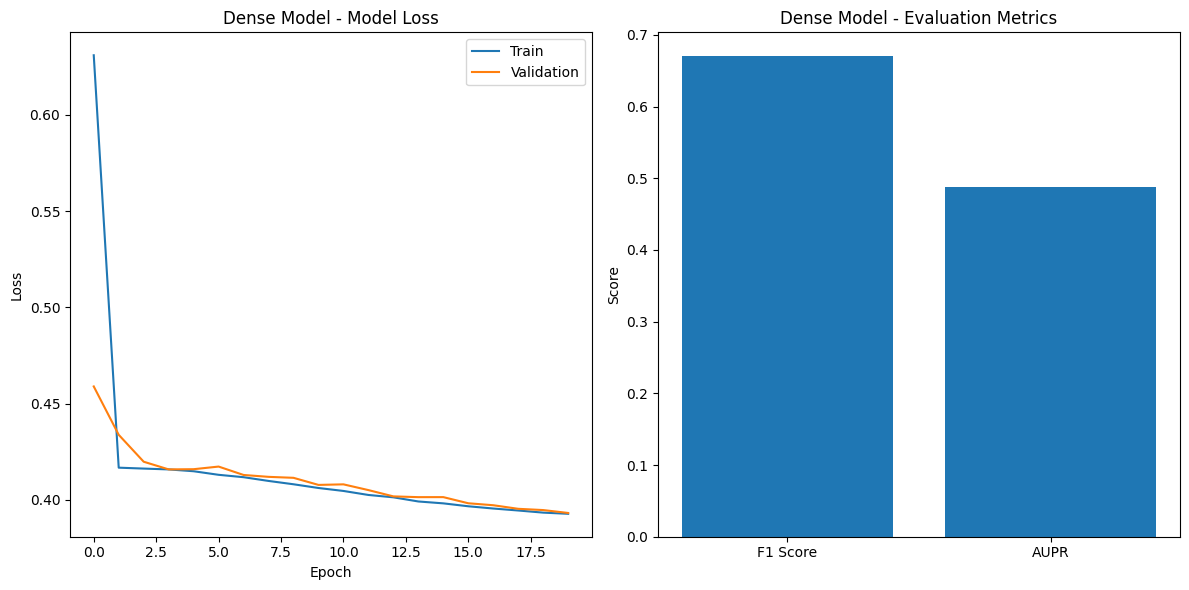

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Dense Model Evaluation:
Loss: 0.3920458257198334
Binary Accuracy: 0.8190178275108337
AUPR: 0.4882409439952556
F1 Score: 0.6700013134294788


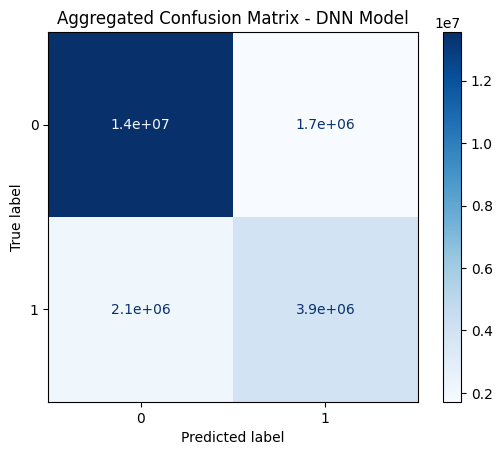

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1000)              1

In [ ]:
# Define the plot_results function
def plot_results(history, scores, f1, aupr, model_name):
    plt.figure(figsize=(12, 6))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} - Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot F1 score and AUPR
    plt.subplot(1, 2, 2)
    plt.bar(['F1 Score', 'AUPR'], [f1, aupr])
    plt.title(f'{model_name} - Evaluation Metrics')
    plt.ylabel('Score')

    plt.tight_layout()
    plt.show()
# Plot results for the Dense model
plot_results(history, dense_scores, dense_f1, dense_aupr, 'Dense Model')

# Save the Dense model
model.save('/content/drive/My Drive/Colab Notebooks/Data/final_dense_model_new_labels.h5')

# Print and save evaluation metrics
print("Dense Model Evaluation:")
print("Loss:", dense_scores[0])
print("Binary Accuracy:", dense_scores[1])
print("AUPR:", dense_aupr)
print("F1 Score:", dense_f1)

if isinstance(y_test, pd.DataFrame):
    y_test = y_test.to_numpy()
if isinstance(dense_predictions, pd.DataFrame):
    dense_predictions = dense_predictions.to_numpy()

# Round the predictions to get binary outcomes
rounded_predictions = np.round(dense_predictions)

# Reshape the arrays into a single dimension
y_test_flat = y_test.ravel()
rounded_predictions_flat = rounded_predictions.ravel()

# Generate the confusion matrix
cm = confusion_matrix(y_test_flat, rounded_predictions_flat)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Aggregated Confusion Matrix - DNN Model')
plt.show()

model.summary()